# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

한국어 텍스트의 감정분석을 진행해 보면 어떨까요?
오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)입니다.

## 데이터 준비와 확인


In [117]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다.  data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
ids = train_data['id']

ids[train_data.duplicated()]

Series([], Name: id, dtype: int64)

In [118]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=25000):
#   document column만 고려
    train_data.drop_duplicates(subset = ['document'], inplace=True)
    # 한 행에 결측치 하나라도 있으면 drop (any)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        # 불용어 목록 내에 포함된 단어가 아닌 경우에만 포함시킨 목록으로 정제
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(25000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # wordlist 로 들어온 list 값들 중 word_to_index 에 있는 값이면 index 값을 넣고, 아니라면 <UNK> 의 index 값을 넣는다.
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    # X_train, X_test 에 대해 진행.
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # y_train, y_test 는 각각 label 값만 갖고 있어야 하고, 이를 numpy array 형태로 변환하여 보낸다.
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [119]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [120]:
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

In [8]:
# encode : 단어 => 숫자
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# decode : 숫자 => 단어
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [121]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
STD_COEF = 2
max_tokens = np.mean(num_tokens) + STD_COEF * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('표준편차 계수 : {0} , 전체 문장의 {1}%가 maxlen 설정값 이내에 포함됩니다. '.format(STD_COEF, np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
표준편차 계수 : 2 , 전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [122]:
STD_COEF = 2.1
max_tokens = np.mean(num_tokens) + STD_COEF * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('표준편차 계수 : {0} , 전체 문장의 {1}%가 maxlen 설정값 이내에 포함됩니다. '.format(STD_COEF, np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  42
표준편차 계수 : 2.1 , 전체 문장의 0.9374881616062333%가 maxlen 설정값 이내에 포함됩니다. 


In [123]:
STD_COEF = 2.2
max_tokens = np.mean(num_tokens) + STD_COEF * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('표준편차 계수 : {0} , 전체 문장의 {1}%가 maxlen 설정값 이내에 포함됩니다. '.format(STD_COEF, np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  44
표준편차 계수 : 2.2 , 전체 문장의 0.9434419138011355%가 maxlen 설정값 이내에 포함됩니다. 


In [124]:
STD_COEF = 2.3
max_tokens = np.mean(num_tokens) + STD_COEF * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('표준편차 계수 : {0} , 전체 문장의 {1}%가 maxlen 설정값 이내에 포함됩니다. '.format(STD_COEF, np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  45
표준편차 계수 : 2.3 , 전체 문장의 0.946190980807724%가 maxlen 설정값 이내에 포함됩니다. 


In [125]:
STD_COEF = 2.4
max_tokens = np.mean(num_tokens) + STD_COEF * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('표준편차 계수 : {0} , 전체 문장의 {1}%가 maxlen 설정값 이내에 포함됩니다. '.format(STD_COEF, np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  46
표준편차 계수 : 2.4 , 전체 문장의 0.9492318482228331%가 maxlen 설정값 이내에 포함됩니다. 


In [126]:
STD_COEF = 2.45
max_tokens = np.mean(num_tokens) + STD_COEF * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('표준편차 계수 : {0} , 전체 문장의 {1}%가 maxlen 설정값 이내에 포함됩니다. '.format(STD_COEF, np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  47
표준편차 계수 : 2.45 , 전체 문장의 0.9521754488351021%가 maxlen 설정값 이내에 포함됩니다. 


표준편차 값에 2.45를 곱했을 때 최대 길이를 기준으로 전체 문장의 95% 가량이 포함되므로, 일단 이 값으로 진행

In [127]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
#                                                         padding='post', # 혹은 'pre'
                                                         padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
#                                                        padding='post', # 혹은 'pre'
                                                        padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 47)


In [128]:
print(X_test.shape)

(49157, 47)


## 모델구성 및 validation set 구성

### validation set 구성
테스트 데이터가 대략 5만개이므로,
validation set 도 대략 5만개로 맞춰주겠다.

In [17]:
VALIDATION_NUM = 50000 
# validation set 10000건 분리
X_val = X_train[:VALIDATION_NUM]   
y_val = y_train[:VALIDATION_NUM]

# validation set을 제외한 나머지 약 10만건
partial_X_train = X_train[VALIDATION_NUM:]  
partial_y_train = y_train[VALIDATION_NUM:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 47)
(96182,)


### 모델 구성

In [18]:
vocab_size = 1000
word_vector_dim = 32 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

In [19]:
# 1. LSTM

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_lstm.add(keras.layers.Dense(8, activation='relu')) m
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 33,393
Trainable params: 33,393
Non-trainable params: 0
_________________________________________________________________


In [21]:
# 2. Conv 1-D
from keras.initializers import Constant

model_conv_1D = keras.Sequential()
model_conv_1D.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_conv_1D.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_conv_1D.add(keras.layers.MaxPooling1D(5))
model_conv_1D.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_conv_1D.add(keras.layers.GlobalMaxPooling1D())
model_conv_1D.add(keras.layers.Dense(8, activation='relu'))
model_conv_1D.add(keras.layers.Dense(1, activation='sigmoid')) 

model_conv_1D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 47, 32)            32000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 16)            3600      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [22]:
# 3. only GlobalMaxPooling
model_global_max_pool_only = keras.Sequential()
model_global_max_pool_only.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_global_max_pool_only.add(keras.layers.GlobalMaxPooling1D())
model_global_max_pool_only.add(keras.layers.Dense(8, activation='relu'))
model_global_max_pool_only.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_global_max_pool_only.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 32,273
Trainable params: 32,273
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련, Loss & Accuracy 시각화

In [23]:
models = [model_lstm, model_conv_1D, model_global_max_pool_only]

### LSTM

In [24]:
m_lstm = models[0]
epochs = 20
m_lstm.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

history = m_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = m_lstm.evaluate(X_test,  y_test, verbose=2)
print('============ results =============')
print(results)

history_dict = history.history
print('============ history_dict =============')
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

Epoch 1/20
188/188 [==============================] - 2s 8ms/step - loss: 0.5233 - accuracy: 0.7657 - val_loss: 0.4109 - val_accuracy: 0.8133
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.4040 - accuracy: 0.8158 - val_loss: 0.3968 - val_accuracy: 0.8171
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3917 - accuracy: 0.8209 - val_loss: 0.3882 - val_accuracy: 0.8202
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3842 - accuracy: 0.8237 - val_loss: 0.3834 - val_accuracy: 0.8212
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3788 - accuracy: 0.8259 - val_loss: 0.3800 - val_accuracy: 0.8238
Epoch 6/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3724 - accuracy: 0.8290 - val_loss: 0.3764 - val_accuracy: 0.8241
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3666 - accuracy: 0.8310 - val_loss: 0.3747 - val_accuracy: 0.8254
Epoch 

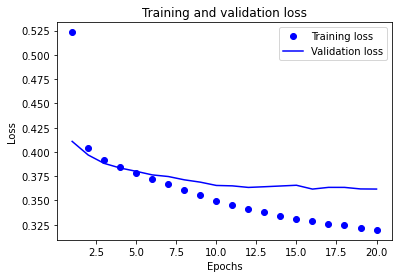

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

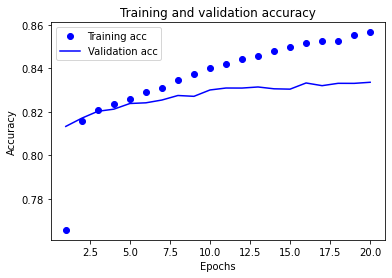

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Conv 1-D

In [27]:
m_conv_1d = models[1]
epochs = 10
m_conv_1d.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

history = m_conv_1d.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = m_conv_1d.evaluate(X_test,  y_test, verbose=2)
print('============ results =============')
print(results)

history_dict = history.history
print('============ history_dict =============')
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

Epoch 1/10
188/188 [==============================] - 9s 47ms/step - loss: 0.5488 - accuracy: 0.7156 - val_loss: 0.4178 - val_accuracy: 0.8029
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.4098 - accuracy: 0.8089 - val_loss: 0.4010 - val_accuracy: 0.8108
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3909 - accuracy: 0.8188 - val_loss: 0.3930 - val_accuracy: 0.8153
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3748 - accuracy: 0.8262 - val_loss: 0.3900 - val_accuracy: 0.8169
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3600 - accuracy: 0.8344 - val_loss: 0.3870 - val_accuracy: 0.8172
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3445 - accuracy: 0.8426 - val_loss: 0.3880 - val_accuracy: 0.8168
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3305 - accuracy: 0.8505 - val_loss: 0.3899 - val_accuracy: 0.8179
Epoch

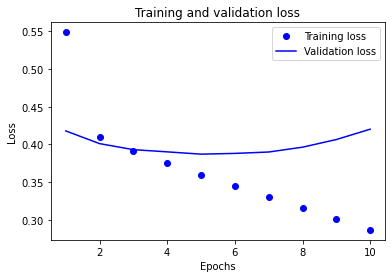

In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

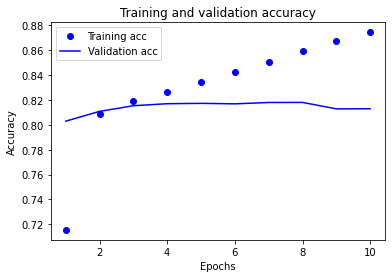

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Global Max Pooling only

In [30]:
m_global_max_pool_only = models[2]
epochs = 20
m_global_max_pool_only.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

history = m_global_max_pool_only.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = m_global_max_pool_only.evaluate(X_test,  y_test, verbose=2)
print('============ results =============')
print(results)

history_dict = history.history
print('============ history_dict =============')
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

Epoch 1/20
188/188 [==============================] - 1s 5ms/step - loss: 0.6038 - accuracy: 0.7392 - val_loss: 0.4537 - val_accuracy: 0.8019
Epoch 2/20
188/188 [==============================] - 1s 4ms/step - loss: 0.4167 - accuracy: 0.8103 - val_loss: 0.4001 - val_accuracy: 0.8142
Epoch 3/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3927 - accuracy: 0.8205 - val_loss: 0.3940 - val_accuracy: 0.8173
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3828 - accuracy: 0.8256 - val_loss: 0.3915 - val_accuracy: 0.8198
Epoch 5/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3746 - accuracy: 0.8304 - val_loss: 0.3900 - val_accuracy: 0.8209
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3678 - accuracy: 0.8343 - val_loss: 0.3891 - val_accuracy: 0.8224
Epoch 7/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3616 - accuracy: 0.8379 - val_loss: 0.3881 - val_accuracy: 0.8224
Epoch 

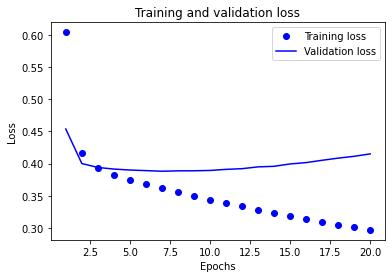

In [31]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

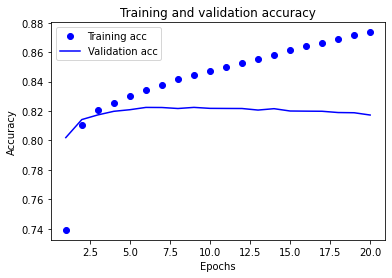

In [32]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

### LSTM

In [33]:
import os

In [35]:
def make_word2vec_file(model,model_name):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)    # shape: (vocab_size, embedding_dim)

    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
    word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_{}.txt'.format(model_name)
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    return word2vec_file_path

In [36]:
word2vec_file_path_lstm = make_word2vec_file(m_lstm,'lstm')

(1000, 32)


In [38]:

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors_lstm['최고']
vector

array([-0.15699987,  0.20237836, -0.18991755, -0.3028242 , -0.21166173,
        0.15814   , -0.36224753, -0.2123565 , -0.3029676 , -0.20412585,
       -0.01549033,  0.17883009,  0.31738263, -0.237644  , -0.33830675,
       -0.11627324, -0.00702407, -0.21330313, -0.01208118,  0.22111797,
       -0.02038234, -0.26721624, -0.2049642 , -0.28503445, -0.24666028,
        0.1897655 , -0.21848053, -0.2483196 ,  0.31462687,  0.2806953 ,
       -0.23707226, -0.18446313], dtype=float32)

In [39]:
word_vectors_lstm.similar_by_word("최고")

[('따뜻', 0.9246723651885986),
 ('훌륭', 0.9193015098571777),
 ('탄탄', 0.9135613441467285),
 ('여운', 0.906825065612793),
 ('깊', 0.9026555418968201),
 ('재', 0.8990644812583923),
 ('명작', 0.8951265215873718),
 ('완벽', 0.8934414386749268),
 ('괜찮', 0.8871896266937256),
 ('♥', 0.8862818479537964)]

그래도 조금은 어울리는듯.

### Conv 1-D

In [40]:
word2vec_file_path_conv_1d = make_word2vec_file(m_conv_1d,'conv_1d')

(1000, 32)


In [41]:
word_vectors_conv_1d = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_conv_1d, binary=False)
vector = word_vectors_conv_1d['최고']
vector

array([-0.04991166, -0.15540025,  0.06970102, -0.20008111, -0.08808339,
       -0.11889354, -0.19448449, -0.00794654,  0.07649592,  0.11155321,
       -0.16393478, -0.1820879 ,  0.19470188, -0.06197189, -0.03627533,
        0.1824708 , -0.04870916,  0.11384879, -0.08227322,  0.04367898,
       -0.0989146 ,  0.09581801,  0.03181709, -0.080869  ,  0.06983015,
       -0.17837605, -0.09034457, -0.2237224 ,  0.08129124, -0.00180825,
       -0.07108055, -0.10034804], dtype=float32)

In [42]:
word_vectors_conv_1d.similar_by_word("최고")

[('수작', 0.839846670627594),
 ('천재', 0.8169498443603516),
 ('걸작', 0.8108124732971191),
 ('♥', 0.7991187572479248),
 ('짱', 0.7863446474075317),
 ('깊', 0.7839892506599426),
 ('완벽', 0.7587078213691711),
 ('밋', 0.75279301404953),
 ('사랑', 0.751909077167511),
 ('명작', 0.7506687641143799)]

꽤 관련이 있어 보인다.

### Max Global Pooling only

In [43]:
word2vec_file_path_max_pool_only = make_word2vec_file(m_global_max_pool_only,'max_pool_only')

(1000, 32)


In [44]:
word_vectors_max_pool_only = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_max_pool_only, binary=False)
vector = word_vectors_max_pool_only['최고']
vector

array([ 0.06031559,  0.18460155, -0.2085219 , -0.19360481, -0.06122852,
        0.14585838,  0.09564763,  0.18873313, -0.16116169,  0.1913557 ,
       -0.17985408,  0.239167  , -0.16783084,  0.24954198, -0.11804666,
        0.12749942, -0.05010912, -0.23702157, -0.00864301, -0.1543952 ,
        0.12298544, -0.0236562 , -0.07535996,  0.23437764,  0.19617823,
        0.02819779,  0.1264574 , -0.07212945, -0.00698926, -0.1091265 ,
        0.02182633,  0.14073814], dtype=float32)

In [45]:
word_vectors_max_pool_only.similar_by_word("최고")

[('노', 0.4488464593887329),
 ('중요', 0.39573270082473755),
 ('없이', 0.38799533247947693),
 ('100', 0.3708416819572449),
 ('존재', 0.36542031168937683),
 ('존', 0.3577790856361389),
 ('밋', 0.35707539319992065),
 ('훨씬', 0.35325947403907776),
 ('가슴', 0.3525121808052063),
 ('날', 0.3460330069065094)]

딱히 관련이 없어보인다.

## 한국어 Word2Vec 임베딩 활용하여 성능개선
https://github.com/Kyubyong/wordvectors

### 불러오기

In [46]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/Desktop/2020_aiffel/daily_notes/exploration_codes/e9_code/ko/ko.bin'
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['최고']
print(vector.shape)
vector

(200,)


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([-1.0152713 , -0.06063395,  2.1013865 , -0.53053313,  0.48102048,
        0.4177825 ,  0.49066627, -1.7467129 , -0.23554218, -0.7802825 ,
        0.25205642, -0.7281079 , -0.5708346 ,  0.21512164,  0.37895873,
       -0.19593605,  1.4408356 , -0.26080552, -0.07197228,  0.9805705 ,
       -0.8030876 ,  0.25228414,  0.9123625 ,  1.2411838 ,  0.13870052,
        1.7325059 , -1.5783826 , -0.01432369,  0.30926976, -1.1689153 ,
       -3.1362064 , -0.31123805, -1.9127095 ,  0.88544   , -1.2766863 ,
       -0.8333593 , -0.11097712, -0.12470332, -2.0818698 , -0.9692228 ,
        0.02903495,  0.15543027, -0.6413738 , -1.7524667 ,  0.00903614,
        0.88036394,  1.8842533 ,  0.88254404,  0.30437934,  0.6343431 ,
        0.09495168, -1.4400343 ,  0.3601637 ,  1.134219  ,  2.3110375 ,
       -0.96069014,  1.9474247 , -1.1871786 , -1.5479655 , -0.50269765,
       -0.77446526, -1.9552984 ,  1.2855368 ,  3.6265228 , -1.9013956 ,
       -2.6395707 , -0.6660882 , -0.56544715,  1.7273039 , -1.93

In [47]:
word2vec.similar_by_word("최고")

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('최대', 0.5721613168716431),
 ('최강', 0.5064553022384644),
 ('유일한', 0.46688494086265564),
 ('일류', 0.46184951066970825),
 ('최악', 0.4529539942741394),
 ('최연소', 0.45037317276000977),
 ('랭킹', 0.4485436677932739),
 ('제일의', 0.4464740753173828),
 ('최초', 0.4450574219226837),
 ('최상', 0.4345606565475464)]

가져온 임베딩을 확인해보니, 비슷한 단어들을 보여주는 것으로 보임

In [135]:
vocab_size = 25000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [136]:
embedding_matrix.shape

(25000, 200)

In [137]:
def get_results_history_dicts(model,history):
    results = model.evaluate(X_test,  y_test, verbose=2)
    print('============ results =============')
    print(results)

    history_dict = history.history
    print('============ history_dict =============')
    print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    return epochs, acc, val_acc, loss, val_loss

In [138]:
def plot_loss(epochs,loss,val_loss):
    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [139]:
def plot_accuracy(epochs,acc,val_acc):
    plt.clf()   # 그림을 초기화합니다

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

### conv 1d

In [54]:
# 1. conv 1d
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 47, 200)           200000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 41, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [55]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 8s 41ms/step - loss: 0.5672 - accuracy: 0.6965 - val_loss: 0.4900 - val_accuracy: 0.7607
Epoch 2/20
188/188 [==============================] - 3s 15ms/step - loss: 0.4498 - accuracy: 0.7863 - val_loss: 0.4391 - val_accuracy: 0.7908
Epoch 3/20
188/188 [==============================] - 3s 15ms/step - loss: 0.4078 - accuracy: 0.8105 - val_loss: 0.4203 - val_accuracy: 0.8022
Epoch 4/20
188/188 [==============================] - 3s 15ms/step - loss: 0.3833 - accuracy: 0.8243 - val_loss: 0.4164 - val_accuracy: 0.8030
Epoch 5/20
188/188 [==============================] - 3s 15ms/step - loss: 0.3674 - accuracy: 0.8320 - val_loss: 0.4155 - val_accuracy: 0.8065
Epoch 6/20
188/188 [==============================] - 3s 15ms/step - loss: 0.3552 - accuracy: 0.8386 - val_loss: 0.4141 - val_accuracy: 0.8058
Epoch 7/20
188/188 [==============================] - 3s 16ms/step - loss: 0.3405 - accuracy: 0.8459 - val_loss: 0.4229 - val_accuracy: 0.8044

In [56]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model,history)

1537/1537 - 3s - loss: 0.5823 - accuracy: 0.7901
============ results =============
[0.582295835018158, 0.7901011109352112]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


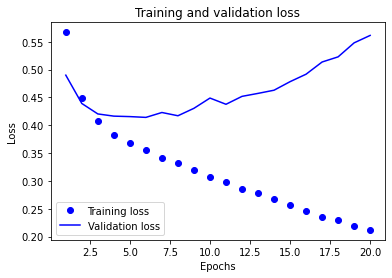

In [58]:
plot_loss(epochs,loss,val_loss)

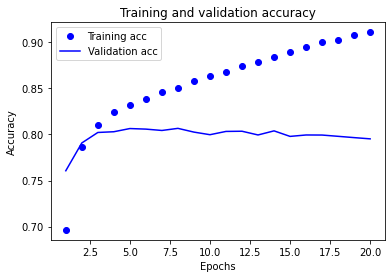

In [60]:
plot_accuracy(epochs,acc,val_acc)

### max polling only

In [78]:
# 2. only GlobalMaxPooling
model_global_max_pool_only = keras.Sequential()
model_global_max_pool_only.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_global_max_pool_only.add(keras.layers.GlobalMaxPooling1D())
model_global_max_pool_only.add(keras.layers.Dense(8, activation='relu'))
model_global_max_pool_only.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_global_max_pool_only.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 47, 200)           200000    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 201,617
Trainable params: 201,617
Non-trainable params: 0
_________________________________________________________________


In [79]:
# 학습의 진행
model_global_max_pool_only.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_global_max_pool_only.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
188/188 [==============================] - 3s 14ms/step - loss: 0.6835 - accuracy: 0.5915 - val_loss: 0.6088 - val_accuracy: 0.6689
Epoch 2/15
188/188 [==============================] - 2s 13ms/step - loss: 0.5784 - accuracy: 0.6991 - val_loss: 0.5518 - val_accuracy: 0.7223
Epoch 3/15
188/188 [==============================] - 2s 13ms/step - loss: 0.5295 - accuracy: 0.7366 - val_loss: 0.5102 - val_accuracy: 0.7505
Epoch 4/15
188/188 [==============================] - 3s 13ms/step - loss: 0.4943 - accuracy: 0.7602 - val_loss: 0.4826 - val_accuracy: 0.7679
Epoch 5/15
188/188 [==============================] - 3s 13ms/step - loss: 0.4698 - accuracy: 0.7752 - val_loss: 0.4655 - val_accuracy: 0.7759
Epoch 6/15
188/188 [==============================] - 2s 13ms/step - loss: 0.4532 - accuracy: 0.7847 - val_loss: 0.4519 - val_accuracy: 0.7836
Epoch 7/15
188/188 [==============================] - 2s 13ms/step - loss: 0.4382 - accuracy: 0.7940 - val_loss: 0.4430 - val_accuracy: 0.7897

In [80]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only,history)

1537/1537 - 2s - loss: 0.4188 - accuracy: 0.8050
============ results =============
[0.41880279779434204, 0.804992139339447]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


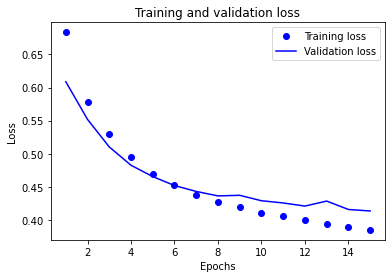

In [81]:
plot_loss(epochs,loss,val_loss)

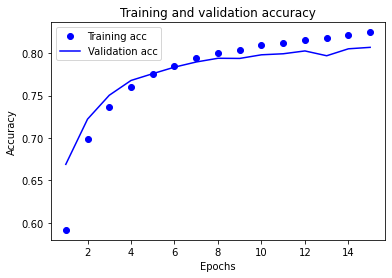

In [82]:
plot_accuracy(epochs,acc,val_acc)

epoch 확 올려서 30?

In [83]:
# 학습의 진행
model_global_max_pool_only.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30

history = model_global_max_pool_only.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/30
188/188 [==============================] - 3s 14ms/step - loss: 0.3814 - accuracy: 0.8257 - val_loss: 0.4124 - val_accuracy: 0.8082
Epoch 2/30
188/188 [==============================] - 3s 13ms/step - loss: 0.3773 - accuracy: 0.8280 - val_loss: 0.4112 - val_accuracy: 0.8093
Epoch 3/30
188/188 [==============================] - 2s 13ms/step - loss: 0.3743 - accuracy: 0.8303 - val_loss: 0.4144 - val_accuracy: 0.8082
Epoch 4/30
188/188 [==============================] - 2s 13ms/step - loss: 0.3699 - accuracy: 0.8323 - val_loss: 0.4173 - val_accuracy: 0.8069
Epoch 5/30
188/188 [==============================] - 2s 13ms/step - loss: 0.3680 - accuracy: 0.8340 - val_loss: 0.4113 - val_accuracy: 0.8098
Epoch 6/30
188/188 [==============================] - 2s 13ms/step - loss: 0.3641 - accuracy: 0.8356 - val_loss: 0.4099 - val_accuracy: 0.8109
Epoch 7/30
188/188 [==============================] - 2s 13ms/step - loss: 0.3622 - accuracy: 0.8366 - val_loss: 0.4094 - val_accuracy: 0.8106

In [84]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only,history)

1537/1537 - 2s - loss: 0.4383 - accuracy: 0.8065
============ results =============
[0.43831053376197815, 0.8065178990364075]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


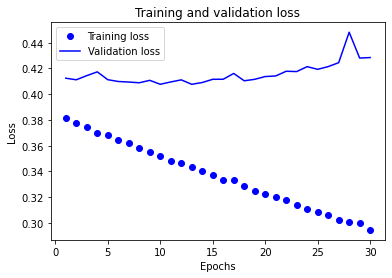

In [85]:
plot_loss(epochs,loss,val_loss)

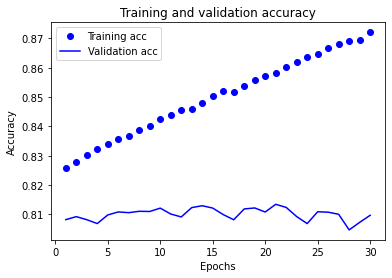

In [86]:
plot_accuracy(epochs,acc,val_acc)

epoch 를 아주 작게 해보자.

In [71]:
# 학습의 진행
model_global_max_pool_only.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=1

history = model_global_max_pool_only.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

188/188 [==============================] - 2s 13ms/step - loss: 0.2967 - accuracy: 0.8718 - val_loss: 0.4214 - val_accuracy: 0.8118


In [87]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only,history)

1537/1537 - 2s - loss: 0.4383 - accuracy: 0.8065
============ results =============
[0.43831053376197815, 0.8065178990364075]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [73]:
# 학습의 진행
model_global_max_pool_only.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=6

history = model_global_max_pool_only.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/6
188/188 [==============================] - 3s 14ms/step - loss: 0.2950 - accuracy: 0.8717 - val_loss: 0.4218 - val_accuracy: 0.8114
Epoch 2/6
188/188 [==============================] - 3s 13ms/step - loss: 0.2916 - accuracy: 0.8740 - val_loss: 0.4270 - val_accuracy: 0.8086
Epoch 3/6
188/188 [==============================] - 2s 13ms/step - loss: 0.2893 - accuracy: 0.8752 - val_loss: 0.4255 - val_accuracy: 0.8111
Epoch 4/6
188/188 [==============================] - 3s 13ms/step - loss: 0.2866 - accuracy: 0.8768 - val_loss: 0.4279 - val_accuracy: 0.8102
Epoch 5/6
188/188 [==============================] - 3s 13ms/step - loss: 0.2842 - accuracy: 0.8778 - val_loss: 0.4325 - val_accuracy: 0.8102
Epoch 6/6
188/188 [==============================] - 3s 14ms/step - loss: 0.2824 - accuracy: 0.8788 - val_loss: 0.4361 - val_accuracy: 0.8077


In [88]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only,history)

1537/1537 - 2s - loss: 0.4383 - accuracy: 0.8065
============ results =============
[0.43831053376197815, 0.8065178990364075]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


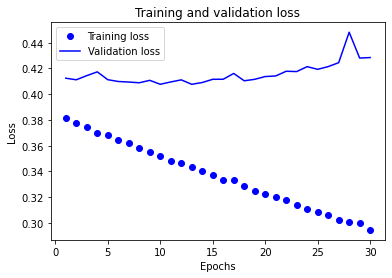

In [89]:
plot_loss(epochs,loss,val_loss)

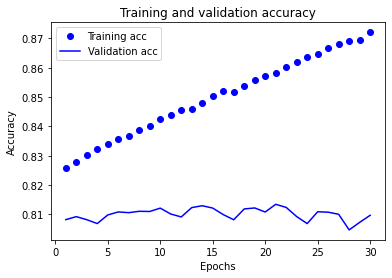

In [90]:
plot_accuracy(epochs,acc,val_acc)

### validation set 크기를 조절해보자.

In [91]:
VALIDATION_NUM = 25000
X_val_half = X_train[:VALIDATION_NUM]   
y_val_half = y_train[:VALIDATION_NUM]

# validation set을 제외한 나머지 약 12.5만건
partial_X_train_half = X_train[VALIDATION_NUM:]  
partial_y_train_half = y_train[VALIDATION_NUM:]

print(partial_X_train_half.shape)
print(partial_y_train_half.shape)

(121182, 47)
(121182,)


In [92]:
# 학습의 진행
model_global_max_pool_only.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_global_max_pool_only.fit(partial_X_train_half,
                    partial_y_train_half,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_half, y_val_half),
                    verbose=1)

Epoch 1/15
237/237 [==============================] - 3s 12ms/step - loss: 0.3220 - accuracy: 0.8592 - val_loss: 0.4242 - val_accuracy: 0.8086
Epoch 2/15
237/237 [==============================] - 3s 12ms/step - loss: 0.3173 - accuracy: 0.8617 - val_loss: 0.4193 - val_accuracy: 0.8125
Epoch 3/15
237/237 [==============================] - 3s 12ms/step - loss: 0.3153 - accuracy: 0.8625 - val_loss: 0.4177 - val_accuracy: 0.8125
Epoch 4/15
237/237 [==============================] - 3s 11ms/step - loss: 0.3135 - accuracy: 0.8634 - val_loss: 0.4261 - val_accuracy: 0.8115
Epoch 5/15
237/237 [==============================] - 3s 11ms/step - loss: 0.3102 - accuracy: 0.8644 - val_loss: 0.4184 - val_accuracy: 0.8138
Epoch 6/15
237/237 [==============================] - 3s 12ms/step - loss: 0.3073 - accuracy: 0.8667 - val_loss: 0.4184 - val_accuracy: 0.8134
Epoch 7/15
237/237 [==============================] - 3s 11ms/step - loss: 0.3038 - accuracy: 0.8683 - val_loss: 0.4196 - val_accuracy: 0.8126

In [93]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only,history)

1537/1537 - 2s - loss: 0.4494 - accuracy: 0.8074
============ results =============
[0.44935935735702515, 0.8073519468307495]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


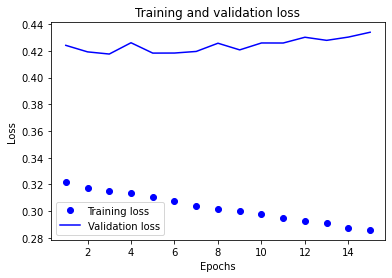

In [94]:
plot_loss(epochs,loss,val_loss)

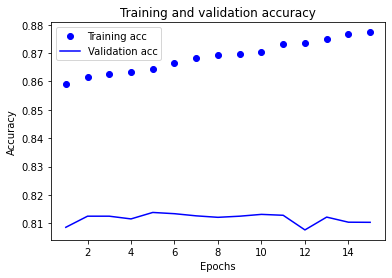

In [95]:
plot_accuracy(epochs,acc,val_acc)

### validation set 을 더 줄여보자.

In [98]:
VALIDATION_NUM = 15000
X_val_half_2 = X_train[:VALIDATION_NUM]   
y_val_half_2 = y_train[:VALIDATION_NUM]

# validation set을 제외한 나머지 약 13.5만건
partial_X_train_half_2 = X_train[VALIDATION_NUM:]  
partial_y_train_half_2 = y_train[VALIDATION_NUM:]

print(partial_X_train_half_2.shape)
print(partial_y_train_half_2.shape)

(131182, 47)
(131182,)


In [100]:
# 학습의 진행
model_global_max_pool_only.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model_global_max_pool_only.fit(partial_X_train_half_2,
                    partial_y_train_half_2,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_half_2, y_val_half_2),
                    verbose=1)

Epoch 1/15
257/257 [==============================] - 3s 11ms/step - loss: 0.2781 - accuracy: 0.8820 - val_loss: 0.4405 - val_accuracy: 0.8074
Epoch 2/15
257/257 [==============================] - 3s 11ms/step - loss: 0.2755 - accuracy: 0.8830 - val_loss: 0.4403 - val_accuracy: 0.8088
Epoch 3/15
257/257 [==============================] - 3s 11ms/step - loss: 0.2745 - accuracy: 0.8836 - val_loss: 0.4596 - val_accuracy: 0.8090
Epoch 4/15
257/257 [==============================] - 3s 11ms/step - loss: 0.2725 - accuracy: 0.8848 - val_loss: 0.4552 - val_accuracy: 0.8107
Epoch 5/15
257/257 [==============================] - 3s 11ms/step - loss: 0.2689 - accuracy: 0.8866 - val_loss: 0.4464 - val_accuracy: 0.8116
Epoch 6/15
257/257 [==============================] - 3s 11ms/step - loss: 0.2675 - accuracy: 0.8865 - val_loss: 0.4637 - val_accuracy: 0.8091
Epoch 7/15
257/257 [==============================] - 3s 11ms/step - loss: 0.2657 - accuracy: 0.8875 - val_loss: 0.4489 - val_accuracy: 0.8103

In [101]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only,history)

1537/1537 - 2s - loss: 0.4959 - accuracy: 0.8017
============ results =============
[0.49594372510910034, 0.8016762733459473]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Dense layer의 param을 바꿔보자

In [102]:
# 2. only GlobalMaxPooling
model_global_max_pool_only_16 = keras.Sequential()
model_global_max_pool_only_16.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_global_max_pool_only_16.add(keras.layers.GlobalMaxPooling1D())
# Desne layer 의 param 을 바꿔보면 어떨까?
DENSE_PARAM = 16
model_global_max_pool_only_16.add(keras.layers.Dense(DENSE_PARAM, activation='relu'))
model_global_max_pool_only_16.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_global_max_pool_only_16.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 47, 200)           200000    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                3216      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 203,233
Trainable params: 203,233
Non-trainable params: 0
_________________________________________________________________


In [103]:
# 학습의 진행
model_global_max_pool_only_16.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model_global_max_pool_only_16.fit(partial_X_train_half_2,
                    partial_y_train_half_2,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_half_2, y_val_half_2),
                    verbose=1)

Epoch 1/15
257/257 [==============================] - 3s 11ms/step - loss: 0.6574 - accuracy: 0.6219 - val_loss: 0.5907 - val_accuracy: 0.6828
Epoch 2/15
257/257 [==============================] - 3s 11ms/step - loss: 0.5533 - accuracy: 0.7170 - val_loss: 0.5206 - val_accuracy: 0.7403
Epoch 3/15
257/257 [==============================] - 3s 11ms/step - loss: 0.4998 - accuracy: 0.7561 - val_loss: 0.4799 - val_accuracy: 0.7647
Epoch 4/15
257/257 [==============================] - 3s 11ms/step - loss: 0.4686 - accuracy: 0.7754 - val_loss: 0.4584 - val_accuracy: 0.7798
Epoch 5/15
257/257 [==============================] - 3s 11ms/step - loss: 0.4481 - accuracy: 0.7881 - val_loss: 0.4425 - val_accuracy: 0.7890
Epoch 6/15
257/257 [==============================] - 3s 11ms/step - loss: 0.4333 - accuracy: 0.7959 - val_loss: 0.4334 - val_accuracy: 0.7953
Epoch 7/15
257/257 [==============================] - 3s 11ms/step - loss: 0.4221 - accuracy: 0.8024 - val_loss: 0.4239 - val_accuracy: 0.7993

In [104]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only_16,history)

1537/1537 - 2s - loss: 0.4170 - accuracy: 0.8086
============ results =============
[0.417038232088089, 0.8085522055625916]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [105]:
# 2. only GlobalMaxPooling
model_global_max_pool_only_32 = keras.Sequential()
model_global_max_pool_only_32.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_global_max_pool_only_32.add(keras.layers.GlobalMaxPooling1D())
# Desne layer 의 param 을 바꿔보면 어떨까?
DENSE_PARAM = 32
model_global_max_pool_only_32.add(keras.layers.Dense(DENSE_PARAM, activation='relu'))
model_global_max_pool_only_32.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_global_max_pool_only_32.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 47, 200)           200000    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 206,465
Trainable params: 206,465
Non-trainable params: 0
_________________________________________________________________


In [106]:
# 학습의 진행
model_global_max_pool_only_32.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=32

history = model_global_max_pool_only_32.fit(partial_X_train_half_2,
                    partial_y_train_half_2,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_half_2, y_val_half_2),
                    verbose=1)

Epoch 1/32
257/257 [==============================] - 3s 12ms/step - loss: 0.6428 - accuracy: 0.6311 - val_loss: 0.5683 - val_accuracy: 0.7051
Epoch 2/32
257/257 [==============================] - 3s 11ms/step - loss: 0.5390 - accuracy: 0.7288 - val_loss: 0.5122 - val_accuracy: 0.7475
Epoch 3/32
257/257 [==============================] - 3s 11ms/step - loss: 0.4905 - accuracy: 0.7617 - val_loss: 0.4848 - val_accuracy: 0.7647
Epoch 4/32
257/257 [==============================] - 3s 11ms/step - loss: 0.4639 - accuracy: 0.7781 - val_loss: 0.4591 - val_accuracy: 0.7777
Epoch 5/32
257/257 [==============================] - 3s 11ms/step - loss: 0.4448 - accuracy: 0.7892 - val_loss: 0.4411 - val_accuracy: 0.7911
Epoch 6/32
257/257 [==============================] - 3s 11ms/step - loss: 0.4306 - accuracy: 0.7981 - val_loss: 0.4306 - val_accuracy: 0.7979
Epoch 7/32
257/257 [==============================] - 3s 11ms/step - loss: 0.4201 - accuracy: 0.8042 - val_loss: 0.4268 - val_accuracy: 0.7976

In [112]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only_32,history)

1537/1537 - 2s - loss: 0.4121 - accuracy: 0.8137
============ results =============
[0.41214409470558167, 0.8136582970619202]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


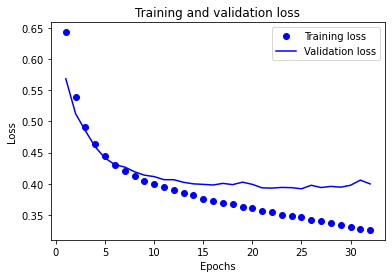

In [113]:
plot_loss(epochs,loss,val_loss)

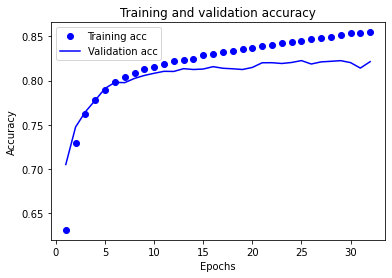

In [114]:
plot_accuracy(epochs,acc,val_acc)

epoch 5로 해보자

In [115]:
# 학습의 진행
model_global_max_pool_only_32.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model_global_max_pool_only_32.fit(partial_X_train_half_2,
                    partial_y_train_half_2,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_half_2, y_val_half_2),
                    verbose=1)

Epoch 1/5
257/257 [==============================] - 3s 11ms/step - loss: 0.3239 - accuracy: 0.8563 - val_loss: 0.3990 - val_accuracy: 0.8191
Epoch 2/5
257/257 [==============================] - 3s 11ms/step - loss: 0.3190 - accuracy: 0.8586 - val_loss: 0.4056 - val_accuracy: 0.8171
Epoch 3/5
257/257 [==============================] - 3s 11ms/step - loss: 0.3199 - accuracy: 0.8587 - val_loss: 0.4003 - val_accuracy: 0.8200
Epoch 4/5
257/257 [==============================] - 3s 11ms/step - loss: 0.3150 - accuracy: 0.8618 - val_loss: 0.4033 - val_accuracy: 0.8195
Epoch 5/5
257/257 [==============================] - 3s 11ms/step - loss: 0.3135 - accuracy: 0.8631 - val_loss: 0.4066 - val_accuracy: 0.8180


In [116]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only_32,history)

1537/1537 - 2s - loss: 0.4176 - accuracy: 0.8114
============ results =============
[0.41763725876808167, 0.8113595247268677]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### word num = 25000


In [132]:
X_train.shape

(146182, 47)

In [143]:
vocab_size

25000

In [129]:
VALIDATION_NUM = 25000
X_val_half = X_train[:VALIDATION_NUM]   
y_val_half = y_train[:VALIDATION_NUM]

# validation set을 제외한 나머지 약 12.5만건
partial_X_train_half = X_train[VALIDATION_NUM:]  
partial_y_train_half = y_train[VALIDATION_NUM:]

print(partial_X_train_half.shape)
print(partial_y_train_half.shape)

(121182, 47)
(121182,)


In [141]:
# 2. only GlobalMaxPooling
model_global_max_pool_only_32 = keras.Sequential()
model_global_max_pool_only_32.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_global_max_pool_only_32.add(keras.layers.GlobalMaxPooling1D())
# Desne layer 의 param 을 바꿔보면 어떨까?
DENSE_PARAM = 32
model_global_max_pool_only_32.add(keras.layers.Dense(DENSE_PARAM, activation='relu'))
model_global_max_pool_only_32.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_global_max_pool_only_32.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 47, 200)           5000000   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 5,006,465
Trainable params: 5,006,465
Non-trainable params: 0
_________________________________________________________________


In [142]:
# 학습의 진행
model_global_max_pool_only_32.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=32

history = model_global_max_pool_only_32.fit(partial_X_train_half,
                    partial_y_train_half,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_half, y_val_half),
                    verbose=1
                                           )

Epoch 1/32
237/237 [==============================] - 10s 40ms/step - loss: 0.6584 - accuracy: 0.6188 - val_loss: 0.5942 - val_accuracy: 0.6856
Epoch 2/32
237/237 [==============================] - 9s 40ms/step - loss: 0.5571 - accuracy: 0.7174 - val_loss: 0.5316 - val_accuracy: 0.7348
Epoch 3/32
237/237 [==============================] - 10s 40ms/step - loss: 0.4957 - accuracy: 0.7608 - val_loss: 0.4791 - val_accuracy: 0.7731
Epoch 4/32
237/237 [==============================] - 9s 40ms/step - loss: 0.4503 - accuracy: 0.7910 - val_loss: 0.4506 - val_accuracy: 0.7880
Epoch 5/32
237/237 [==============================] - 9s 40ms/step - loss: 0.4146 - accuracy: 0.8119 - val_loss: 0.4306 - val_accuracy: 0.8000
Epoch 6/32
237/237 [==============================] - 9s 40ms/step - loss: 0.3865 - accuracy: 0.8281 - val_loss: 0.4198 - val_accuracy: 0.8071
Epoch 7/32
237/237 [==============================] - 9s 40ms/step - loss: 0.3637 - accuracy: 0.8399 - val_loss: 0.4174 - val_accuracy: 0.81

In [144]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only_32,history)

1537/1537 - 2s - loss: 0.6206 - accuracy: 0.8135
============ results =============
[0.6205623149871826, 0.8135159015655518]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


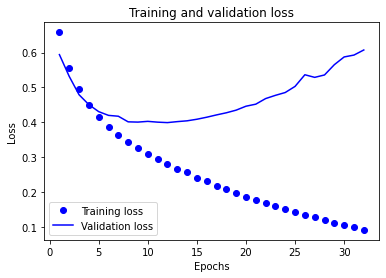

In [145]:
plot_loss(epochs,loss,val_loss)

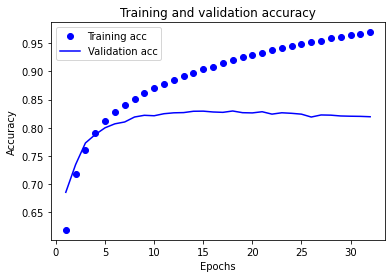

In [146]:
plot_accuracy(epochs,acc,val_acc)

epoch 4 로 해보자

In [147]:
# 학습의 진행
model_global_max_pool_only_32.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4

history = model_global_max_pool_only_32.fit(partial_X_train_half,
                    partial_y_train_half,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_half, y_val_half),
                    verbose=1
                                           )

Epoch 1/4
237/237 [==============================] - 10s 41ms/step - loss: 0.0866 - accuracy: 0.9714 - val_loss: 0.6306 - val_accuracy: 0.8182
Epoch 2/4
237/237 [==============================] - 10s 41ms/step - loss: 0.0817 - accuracy: 0.9728 - val_loss: 0.6676 - val_accuracy: 0.8169
Epoch 3/4
237/237 [==============================] - 10s 41ms/step - loss: 0.0762 - accuracy: 0.9752 - val_loss: 0.6752 - val_accuracy: 0.8135
Epoch 4/4
237/237 [==============================] - 9s 40ms/step - loss: 0.0715 - accuracy: 0.9768 - val_loss: 0.6914 - val_accuracy: 0.8166


In [148]:
epochs, acc, val_acc, loss, val_loss = get_results_history_dicts(model_global_max_pool_only_32,history)

1537/1537 - 2s - loss: 0.7062 - accuracy: 0.8119
============ results =============
[0.7061786651611328, 0.8119494915008545]
============ history_dict =============
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 비교
1. num_words 값을 10000 으로 했을 때

word2vec 사용 전
(loss, accuracy)
- lstm : (1.8541574478149414, 0.8159570097923279)
- conv1d : (1.730568289756775, 0.8108916282653809)
- max-pool-only : (1.0981934070587158, 0.8334926962852478)

word2vec 사용 이후
(loss, accuracy)
- conv1d : (1.470225214958191, 0.8048904538154602) => 오히려 더 이상해졌다?
- max-pool , 15 epochs : (0.4099375903606415, 0.8177472352981567) => 그나마 좀 낫다.
- max-pool , 30 epochs : (0.6902819275856018, 0.8073112964630127) => 너무 많이하면 오히려 떨어진다.
- max-pool , 6 epochs : (0.8152626752853394, 0.805297315120697)

word2vec 사용 및 validation size 조절
(loss,accuracy)
- max-pool, 15 epochs : (0.40289995074272156, 0.8272067308425903)
- max-pool, 4 epochs : (0.4161044955253601, 0.828427255153656)

word2vec 사용 및 validation size 더 조절, Dense Layer param 변경
- max-pool, param 16, 15 epochs : (0.4067070782184601, 0.8254368901252747)
- max-pool, param 32, 32 epochs : (0.6002033948898315, 0.8145330548286438)
- max-pool, param 32, 4 epochs : (0.6794734001159668, 0.8085928559303284)

2. num_words 값을 1000으로 했을 때
별 차이 없다
가장 좋은 결과가 (0.41214409470558167, 0.8136582970619202)

3. num_words 25000으로 해보면?
별 차이 없다
(0.6205623149871826, 0.8135159015655518)
(0.7061786651611328, 0.8119494915008545)



# 결과 보고서

자연어 처리에 주로 사용되는 RNN 모델에 대해 cs231n 강의를 듣기 전 실습을 통해 모델의 핵심 아이디어에 대해 학습해볼 수 있었다. 그리고 자연어 처리를 체험해보았는데, 역시나 매우 어려운 작업이라고 느껴졌다.   
이미 만들어진 임베딩을 조금 살펴보니 제대로된 기능을 하는 것처럼 보였지만, 모델에 적용시켜도 모델이 좋아지지 않았다. 그래도, validation size를 조절하니 성능이 조금 좋아졌다.    
